In [1]:
!pip install --upgrade pip
!pip install pyathena

In [2]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

In [3]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer 

In [4]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


In [5]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#date_to_compare1 = '2023-01-01'
#date_to_compare2 = '2023-05-01'
#Pongo el mes para el que traigo los datos y para poenr en el nombre del parquet
mes_data = '202301' #8:37 ahora 3200
#Pongo uno si quiero generar los datos para el test
archivo_test = 0

df_source = pd.read_sql('''SELECT id_branch, id_receiver, hour_receiver, day_name_receiver, net_amount_receiver, id_payout, 
            receiver_transaction_count, id_country_receiver_claim,
            id_state, branch_working_days, sender_sending_days, sender_days_to_last_transaction, sender_minutes_since_last_transaction, branch_minutes_since_last_transaction, fraud_type
            FROM analytics.source_fraud_fechas_label 
            where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-02-01'  as date);''', conn)


/tmp/ipykernel_14733/2756731093.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [49]:
#cursor = connect(region_name='us-east-1', s3_staging_dir=f'{bucket_name}queryresults/').cursor()
#cursor.execute('''SELECT * FROM analytics.source_fraud_fechas_label 
#            where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-02-01'  as date);''')



In [53]:
#from pyathena.pandas_cursor import PandasCursor
#from pyathena.pandas.util import as_pandas

#prueba = as_pandas(cursor)
#prueba.head(5)


KeyboardInterrupt



In [6]:
#Traigo los percentiles que voy a usar en la normalizacion de algunas variables
df_perc = pd.read_sql('''select 'receiver_transaction_count', ptile, min(receiver_transaction_count), max(receiver_transaction_count), avg(receiver_transaction_count)
from (select NTILE(100) OVER (order by receiver_transaction_count) as ptile, receiver_transaction_count
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01')
where ptile = 1 or ptile = 99
group by ptile
union 
select 'sender_sending_days', ptile, min(sender_sending_days), max(sender_sending_days), avg(sender_sending_days)
from (select NTILE(100) OVER (order by sender_sending_days) as ptile, sender_sending_days
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01')
where ptile = 1 or ptile = 99
group by ptile
union
select 'branch_working_days', ptile, min(branch_working_days), max(branch_working_days), avg(branch_working_days)
from (select NTILE(100) OVER (order by branch_working_days) as ptile, branch_working_days
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01')
where ptile = 1 or ptile = 99
group by ptile
union
select 'net_amount_receiver', ptile, min(net_amount_receiver), max(net_amount_receiver), avg(net_amount_receiver)
from (select NTILE(100) OVER (order by net_amount_receiver) as ptile, net_amount_receiver
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01')
where ptile = 1 or ptile = 99
group by ptile
union
select 'sender_minutes_since_last_transaction', ptile, min(sender_minutes_since_last_transaction), max(sender_minutes_since_last_transaction), avg(sender_minutes_since_last_transaction)
from (select NTILE(100) OVER (order by sender_minutes_since_last_transaction) as ptile, sender_minutes_since_last_transaction
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01' and cast(sender_minutes_since_last_transaction as integer) <2880)
where ptile = 1 or ptile = 99
group by ptile
union
select 'sender_days_to_last_transaction', ptile, min(sender_days_to_last_transaction), max(sender_days_to_last_transaction), avg(sender_days_to_last_transaction)
from (select NTILE(100) OVER (order by sender_days_to_last_transaction) as ptile, sender_days_to_last_transaction
    from analytics.source_fraud_fechas_label
    where date_receiver between '2023-01-01' and '2023-08-01' and cast(sender_days_to_last_transaction as integer) <365)
where ptile = 1 or ptile = 99
group by ptile;''',conn)

/tmp/ipykernel_14733/3476385601.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perc = pd.read_sql('''select 'receiver_transaction_count', ptile, min(receiver_transaction_count), max(receiver_transaction_count), avg(receiver_transaction_count)


In [7]:
df_source.head()

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,sender_days_to_last_transaction,day,date_receiver2,id_sender2,state_sender,fraud_type,date_receiver_clean,tx_brancity,tx_brancity_total,ptx_brancity
0,A21773,16793,2023-01-17 14:16:17.460000000,14.0,Tuesday,192.31,P,0,0,0,...,339,2023-01-17,2023-01-17 14:16:17.460,542.0,NY,None,2023-01-17,12,38,0.315789
1,A21773,16793,2023-01-17 14:16:17.460000000,14.0,Tuesday,192.31,P,0,0,0,...,339,2023-01-17,2023-01-17 14:16:17.460,542.0,NY,None,2023-01-17,12,38,0.315789
2,A10444,27273,2023-01-17 14:39:45.390000000,14.0,Tuesday,300.00,C,0,0,0,...,216,2023-01-17,2023-01-17 14:39:45.390,3255.0,SC,None,2023-01-17,3,39,0.076923
3,A10444,27273,2023-01-17 14:39:45.390000000,14.0,Tuesday,300.00,C,0,0,0,...,216,2023-01-17,2023-01-17 14:39:45.390,3255.0,NC,None,2023-01-17,3,39,0.076923
4,A10444,27273,2023-01-17 14:39:45.390000000,14.0,Tuesday,300.00,C,0,0,0,...,216,2023-01-17,2023-01-17 14:39:45.390,3255.0,SC,None,2023-01-17,3,39,0.076923


In [8]:
df_source['mes'] = df_source['date_receiver_clean'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

In [9]:
## Traigo precentiles para normalizar

In [10]:
df_perc = df_perc.rename(columns={"_col0": "Variable", "_col2": "Min", "_col3": "Max", "_col4": "Avg"})
df_perc

,Variable,ptile,Min,Max,Avg
0,sender_days_to_last_transaction,1,0.0,0.0,0.000000
1,sender_minutes_since_last_transaction,99,2840.0,2862.0,2851.771771
2,sender_days_to_last_transaction,99,346.0,352.0,349.210243
3,sender_minutes_since_last_transaction,1,0.0,0.0,0.000000
4,net_amount_receiver,1,0.0,1.0,0.999995
5,net_amount_receiver,99,2000.0,2500.0,2187.859059
6,sender_sending_days,99,566.0,567.0,566.040980
7,sender_sending_days,1,0.0,13.0,3.760312
8,receiver_transaction_count,1,1.0,1.0,1.000000
9,receiver_transaction_count,99,517.0,517.0,517.000000


## Defino funciones para los datos
### creo_dummies y escalo_percentiles

In [11]:
#defino funcion para normalizar
def escalo_percentiles(data, Pmin, Pmax, calculo):
    #Escalo por Quartiles
    
    m = data.min()
    M = data.max()
    if calculo==1:
        Qmin = Pmin
        Qmax = Pmax
        q0 = data.quantile(Qmin)
        q1 = data.quantile(Qmax)
    elif calculo==0:
            q0=Pmin
            q1=Pmax
    data_std = (data - q0) / (q1 - q0)
    dataN =  data_std.to_numpy()
    #Pongo los outliers con un maximo
    dataN = np.clip(dataN,0,1)
    return dataN

In [12]:
#creo dummies a partir de la lista de variables
def creo_dummies(df, todummy_list):
    df0 = df.copy()
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis = 1)
        df = pd.concat([df, dummies], axis=1)
        df = pd.DataFrame(df)
    return df, df.columns.difference(df0.columns)

## Creo las nuevas variables
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_minutes_since_last_transaction_2days
### net_amount_receiver?

In [13]:
#defino corte en funcion deñ percenti
df_source['sender_days_to_last_transaction'].describe()

count    8.503870e+06
mean     2.949180e+02
std      8.794249e+01
min      0.000000e+00
25%      2.950000e+02
50%      3.330000e+02
75%      3.420000e+02
max      3.640000e+02
Name: sender_days_to_last_transaction, dtype: float64

In [14]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction']
df_source['sender_days_to_last_transaction_more365'] = 0
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0 

/tmp/ipykernel_14733/461507757.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
/tmp/ipykernel_14733/461507757.py:5: SettingWithCopyW

In [15]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction']
df_source['sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction']
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0

/tmp/ipykernel_14733/2804084275.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
/tmp/ipykernel_14733/2804084275.py:5: 

## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [16]:
#df_source['receiver_transaction_count'].describe()

In [17]:
Mx = df_perc.Max[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==1)].item()
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], mn, Mx, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_receiver_transaction_count', ylabel='Count'>

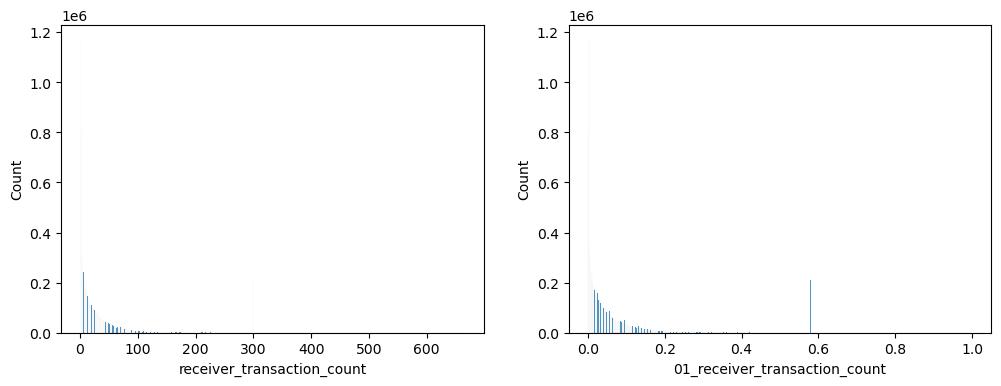

In [18]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])

In [19]:
#df_source['01_receiver_transaction_count'].describe()

In [20]:
#df_source['sender_sending_days'].describe()

In [21]:
Mx = df_perc.Max[(df_perc['Variable']=='sender_sending_days') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='sender_sending_days') & (df_perc['ptile']==1)].item()
df_source['01_sender_sending_days'] = escalo_percentiles(df_source['sender_sending_days'], mn, Mx, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_sending_days', ylabel='Count'>

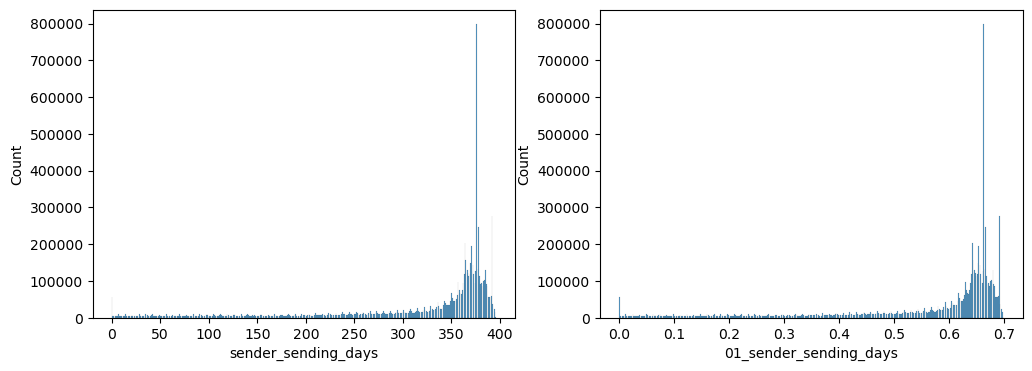

In [22]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [23]:
#df_source['branch_working_days'].describe()

In [24]:
#df_source['net_amount_receiver'].describe()

In [25]:
#df_source['sender_minutes_since_last_transaction_2days'].describe()

In [26]:
#df_source['sender_minutes_since_last_transaction_1day'].describe()

In [27]:
#df_source['sender_days_to_last_transaction_365'].describe()

In [28]:
#df_source['branch_minutes_since_last_transaction'].describe()

In [29]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
Mx = df_perc.Max[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==1)].item()
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], mn, Mx, 0)

Mx = df_perc.Max[(df_perc['Variable']=='branch_working_days') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='branch_working_days') & (df_perc['ptile']==1)].item()
df_source['01_branch_working_days'] = escalo_percentiles(df_source['branch_working_days'], mn, Mx, 0)

Mx = df_perc.Max[(df_perc['Variable']=='net_amount_receiver') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='net_amount_receiver') & (df_perc['ptile']==1)].item()
df_source['01_net_amount_receiver'] = escalo_percentiles(df_source['net_amount_receiver'], mn, Mx, 0)

Mx = 2880
mn = 0
df_source['01_sender_minutes_since_last_transaction_2days'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_2days'], mn, Mx, 0)

Mx = 1440
mn = 0
df_source['01_sender_minutes_since_last_transaction_1day'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_1day'], mn, Mx, 0)

Mx = 365
mn = 0
df_source['01_sender_days_to_last_transaction_365'] = escalo_percentiles(df_source['sender_days_to_last_transaction_365'], mn, Mx, 0)


In [30]:
#Agregadas
Mx = 24
mn = 0
df_source['01_hour_receiver'] = escalo_percentiles(df_source['hour_receiver'], mn, Mx, 0)
df_source['01_isMexico'] = (df_source['id_country_receiver_claim']=='MX')


In [31]:
df_source['01_receiver_transaction_count'].describe()
df_source['01_sender_sending_days'].describe()
df_source['01_branch_working_days'].describe()
df_source['01_net_amount_receiver'].describe()
df_source['01_sender_minutes_since_last_transaction_2days'].describe()
df_source['01_sender_minutes_since_last_transaction_1day'].describe()
df_source['01_sender_days_to_last_transaction_365'].describe()

count    8.503870e+06
mean     8.079944e-01
std      2.409383e-01
min      0.000000e+00
25%      8.082192e-01
50%      9.123288e-01
75%      9.369863e-01
max      9.972603e-01
Name: 01_sender_days_to_last_transaction_365, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_days_to_last_transaction_365', ylabel='Count'>

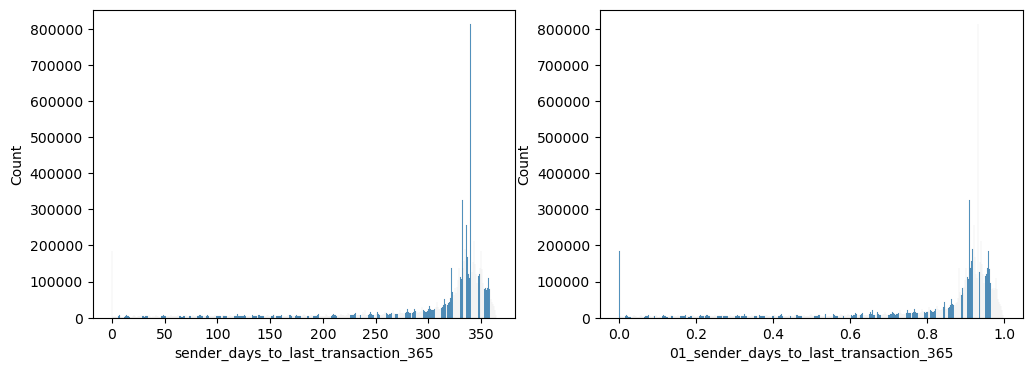

In [32]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_days_to_last_transaction_365", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_days_to_last_transaction_365", ax = axs[1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


sender_days_to_last_transaction_more365
0    8503870
Name: count, dtype: int64

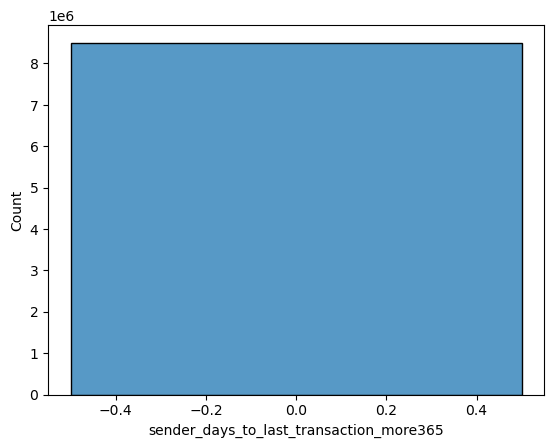

In [33]:
sns.histplot(data=df_source, x='sender_days_to_last_transaction_more365')
df_source['sender_days_to_last_transaction_more365'].value_counts()

## Creo Variables dummy

In [34]:
todummy_list = ['day_name_receiver','id_payout']
[df_source, var_nuevas] = creo_dummies(df_source, todummy_list)

## Creacion del target

In [35]:
df_source['fraud_type'].value_counts()

fraud_type
Remote access    3861
Payment            92
Name: count, dtype: int64

In [36]:
# defino los targets
df_source['target1'] = df_source['fraud_type'] == 'Remote access'
df_source['target2'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [37]:
df_source['target1'].value_counts()

target1
False    8500009
True        3861
Name: count, dtype: int64

In [38]:
df_source['target2'].value_counts()

target2
False    8503778
True          92
Name: count, dtype: int64

In [39]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    8499917
True        3953
Name: count, dtype: int64

In [43]:
archivo_test = 0

In [42]:
df_source.columns.values

array(['id_branch', 'id_receiver', 'date_receiver', 'hour_receiver',
       'net_amount_receiver', 'was_fraud', 'was_fraud_pattern',
       'was_ofac_receiver_hit', 'was_ofac_sender_hit',
       'receiver_transaction_count', 'id_country_receiver_claim',
       'id_city', 'id_state', 'id_location', 'branch_working_days',
       'sender_sending_days', 'sender_days_since_last_transaction',
       'id_payer', 'id_sender_global',
       'sender_minutes_since_last_transaction',
       'branch_minutes_since_last_transaction',
       'sender_days_to_last_transaction', 'day', 'date_receiver2',
       'id_sender2', 'state_sender', 'fraud_type', 'date_receiver_clean',
       'tx_brancity', 'tx_brancity_total', 'ptx_brancity', 'mes',
       'sender_days_to_last_transaction_365',
       'sender_days_to_last_transaction_more365',
       'sender_minutes_since_last_transaction_2days',
       'sender_minutes_since_last_transaction_1day',
       '01_receiver_transaction_count', '01_sender_sending_days',

## Guardo archivos para dsp juntar en el entrenamiento

In [44]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df = df_source [['id_branch','id_receiver','id_sender_global',
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365','sender_days_to_last_transaction_more365',
            '01_hour_receiver','01_isMexico','tx_brancity', 'tx_brancity_total', 'ptx_brancity']]
df = pd.concat([df, df_source[var_nuevas]], axis=1)
df = pd.concat([df, df_source[['target1','target2','target_fraudes']]], axis=1)

##'sender_days_since_last_transaction','sender_minutes_since_last_transaction'
#'id_branch', 'id_receiver', 'hour_receiver','day_name_receiver','net_amount_receiver','was_ofac_receiver_hit','was_ofac_sender_hit',
#'receiver_transaction_count','branch_working_days','sender_sending_days','branch_minutes_since_last_transaction','sender_days_to_last_transaction',
#'fraud_type','date_receiver_clean','target1','target2',

In [45]:
df

,id_branch,id_receiver,id_sender_global,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,target1,target2,target_fraudes
0,A21773,16793,7866564,0.000000,0.261023,0.095771,0.076924,0.000694,0.001389,0.928767,...,False,False,False,True,False,False,False,False,False,False
1,A21773,16793,7866564,0.000000,0.261023,0.095771,0.076924,0.000694,0.001389,0.928767,...,False,False,False,True,False,False,False,False,False,False
2,A10444,27273,9510495,0.019380,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False
3,A10444,27273,9510495,0.019380,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False
4,A10444,27273,9510495,0.019380,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8503865,A20524,19645,9548783,0.000000,0.005291,0.146588,1.000000,0.000000,0.000000,0.391781,...,False,False,False,False,False,False,False,False,False,False
8503866,A18992,12329,6947840,0.050388,0.520282,0.200426,0.036000,0.000000,0.000000,0.917808,...,False,False,False,True,False,False,False,False,False,False
8503867,A18992,12329,6947840,0.050388,0.520282,0.200426,0.036000,0.000000,0.000000,0.917808,...,False,False,False,True,False,False,False,False,False,False
8503868,A18992,12329,6947840,0.050388,0.520282,0.200426,0.036000,0.000000,0.000000,0.917808,...,False,False,False,True,False,False,False,False,False,False


In [46]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
#guardar_dataset_con_valor_parquet(df_source, columna_nombre='mes', nombre_archivo='Prepoc_Fraude',carpeta='ABT') # save ABT in parquet format

In [47]:
if archivo_test == 0:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
elif archivo_test ==1:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Test/Preproc_Fr_{mes_data}.parquet"
#df.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
df.to_parquet(path=s3_url, engine='pyarrow', compression='gzip')
print('termine de salvar el parquet')

termine de salvar el parquet


In [48]:
df.head(5)

,id_branch,id_receiver,id_sender_global,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,target1,target2,target_fraudes
0,A21773,16793,7866564,0.00000,0.261023,0.095771,0.076924,0.000694,0.001389,0.928767,...,False,False,False,True,False,False,False,False,False,False
1,A21773,16793,7866564,0.00000,0.261023,0.095771,0.076924,0.000694,0.001389,0.928767,...,False,False,False,True,False,False,False,False,False,False
2,A10444,27273,9510495,0.01938,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False
3,A10444,27273,9510495,0.01938,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False
4,A10444,27273,9510495,0.01938,0.022928,0.586709,0.120000,0.000000,0.000000,0.591781,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
mes_data